# 04_model_cnn_lstm.ipynb

CNN-LSTM (sequence model) for Driver Drowsiness Detection.

- Loads preprocessed frame arrays (data/processed/*.npy)
- Synthesizes short sequences (T frames) per class from the image dataset
- Builds a TimeDistributed CNN + LSTM classifier
- Trains, evaluates, saves results and the model


In [10]:
import os, json, time, numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models

# Paths
PROCESSED_DIR = "../data/processed"
MODEL_DIR     = "models"
RESULTS_DIR   = "results"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Classes
CLASS_NAMES = ["Closed_Eyes","Open_Eyes","Yawn","No_Yawn"]
num_classes = len(CLASS_NAMES)

# Reproducibility
tf.random.set_seed(42); np.random.seed(42)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [11]:
# Load preprocessed single frames
X_train = np.load(f"{PROCESSED_DIR}/X_train.npy")
y_train = np.load(f"{PROCESSED_DIR}/y_train.npy")
X_val   = np.load(f"{PROCESSED_DIR}/X_val.npy")
y_val   = np.load(f"{PROCESSED_DIR}/y_val.npy")
X_test  = np.load(f"{PROCESSED_DIR}/X_test.npy")
y_test  = np.load(f"{PROCESSED_DIR}/y_test.npy")

H,W,C = X_train.shape[1:]
print("Frames loaded:")
print("  Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)


Frames loaded:
  Train: (1726, 64, 64, 3)  Val: (496, 64, 64, 3)  Test: (245, 64, 64, 3)


In [12]:
# Sequence synthesis settings
T = 8                      # sequence length
STRATEGY = "random"        # 'random' | 'block'
SEQS_PER_CLASS_TRAIN = 400  # caps (auto-adjusted)
SEQS_PER_CLASS_VAL   = 120
SEQS_PER_CLASS_TEST  = 120

def index_by_class(y):
    buckets = defaultdict(list)
    for idx, label in enumerate(y):
        buckets[int(label)].append(idx)
    return buckets

def build_sequences_from_frames(X, y, T, seqs_per_class, strategy="random"):
    buckets = index_by_class(y)
    X_seqs, y_seqs = [], []
    for cls, idxs in buckets.items():
        idxs = np.array(idxs)
        n_avail = len(idxs)
        n_make = min(seqs_per_class, max(1, n_avail // max(1, T//2)))
        for _ in range(n_make):
            if strategy == "random":
                chosen = np.random.choice(idxs, size=T, replace=True)
            else:
                np.random.shuffle(idxs)
                start = np.random.randint(0, max(1, len(idxs)-T+1))
                chosen = idxs[start:start+T]
                if len(chosen) < T:
                    chosen = np.pad(chosen, (0, T-len(chosen)), mode="edge")
            seq = X[chosen]
            X_seqs.append(seq)
            y_seqs.append(cls)
    X_seqs = np.array(X_seqs, dtype=X.dtype)
    y_seqs = np.array(y_seqs, dtype=np.int64)
    return X_seqs, y_seqs

# Build sequences for each split
Xtr_seq, ytr_seq = build_sequences_from_frames(X_train, y_train, T, SEQS_PER_CLASS_TRAIN, STRATEGY)
Xva_seq, yva_seq = build_sequences_from_frames(X_val,   y_val,   T, SEQS_PER_CLASS_VAL,   STRATEGY)
Xte_seq, yte_seq = build_sequences_from_frames(X_test,  y_test,  T, SEQS_PER_CLASS_TEST,  STRATEGY)

print("Sequences built:")
print("  Train:", Xtr_seq.shape, " Val:", Xva_seq.shape, " Test:", Xte_seq.shape)
print("  Class dist (train):", Counter(ytr_seq))


Sequences built:
  Train: (430, 8, 64, 64, 3)  Val: (124, 8, 64, 64, 3)  Test: (60, 8, 64, 64, 3)
  Class dist (train): Counter({np.int64(0): 108, np.int64(1): 108, np.int64(3): 107, np.int64(2): 107})


In [14]:
classes = np.arange(num_classes)
class_weights = compute_class_weight("balanced", classes=classes, y=ytr_seq)
class_weights = {int(i): float(w) for i,w in enumerate(class_weights)}
class_weights


{0: 0.9953703703703703,
 1: 0.9953703703703703,
 2: 1.0046728971962617,
 3: 1.0046728971962617}

In [15]:
def build_cnn_backbone(input_shape_frame=(64,64,3)):
    inp = layers.Input(shape=input_shape_frame)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)  # (F,)
    return models.Model(inp, x, name="frame_cnn")

frame_cnn = build_cnn_backbone((H,W,C))

seq_input = layers.Input(shape=(None, H, W, C))  # (T,H,W,C)
x = layers.TimeDistributed(frame_cnn)(seq_input)  # (T, F)
x = layers.LSTM(128, return_sequences=False)(x)
x = layers.Dropout(0.35)(x)
out = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(seq_input, out, name="cnn_lstm")
model.summary()


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 64, 64,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 128)      │        93,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,348 (880.27 KB)

 Trainable params: 225,348 (880.27 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
run_id = time.strftime("%Y%m%d-%H%M%S") + "_cnnlstm"
ckpt_path = f"{MODEL_DIR}/cnn_lstm_best_{run_id}.keras"
log_dir   = f"{RESULTS_DIR}/logs_{run_id}"

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    TensorBoard(log_dir=log_dir)
]

print("Checkpoint:", ckpt_path)
print("Logs     :", log_dir)


Checkpoint: models/cnn_lstm_best_20251011-173456_cnnlstm.keras
Logs     : results/logs_20251011-173456_cnnlstm


In [17]:
history = model.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xva_seq, yva_seq),
    epochs=35,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.2358 - loss: 1.3643
Epoch 1: val_accuracy improved from None to 0.53226, saving model to models/cnn_lstm_best_20251011-173456_cnnlstm.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - accuracy: 0.2605 - loss: 1.3202 - val_accuracy: 0.5323 - val_loss: 1.1004 - learning_rate: 0.0010
Epoch 2/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5504 - loss: 0.9707
Epoch 2: val_accuracy did not improve from 0.53226
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 422ms/step - accuracy: 0.5349 - loss: 0.8492 - val_accuracy: 0.5000 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 3/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5254 - loss: 0.7929
Epoch 3: val_accuracy improved from 0.53226 to 0.62097, saving model to models/cnn_lstm_best_20251011-173456_cnnlstm.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - accuracy: 0.5488 - loss: 0.7543 - val_accuracy: 0.6210 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 4/35
14/14 ━━━━━━━━

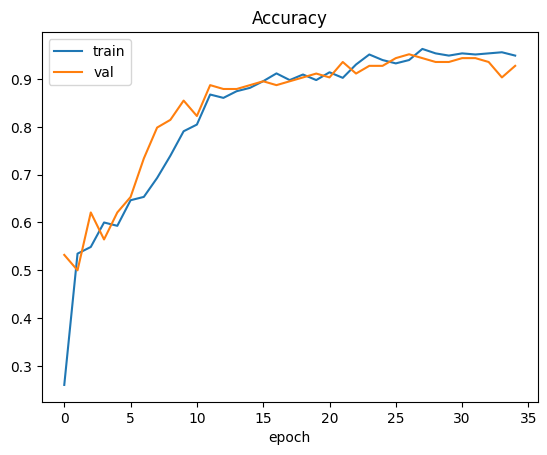

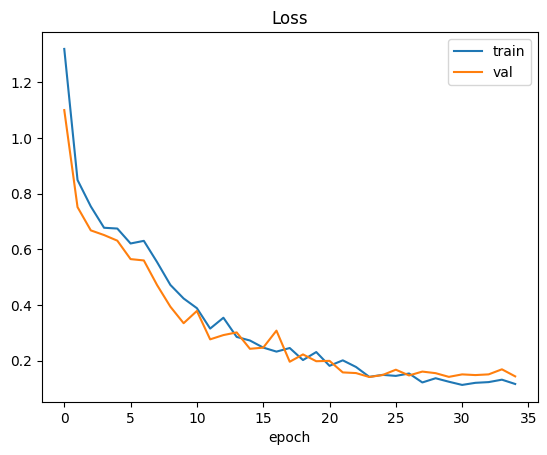

In [18]:
h = history.history
plt.figure(); plt.plot(h["accuracy"], label="train"); plt.plot(h["val_accuracy"], label="val");
plt.title("Accuracy"); plt.xlabel("epoch"); plt.legend(); plt.show()
plt.figure(); plt.plot(h["loss"], label="train"); plt.plot(h["val_loss"], label="val");
plt.title("Loss"); plt.xlabel("epoch"); plt.legend(); plt.show()


Test accuracy: 0.8667
              precision    recall  f1-score   support

 Closed_Eyes       1.00      1.00      1.00        15
   Open_Eyes       1.00      1.00      1.00        15
        Yawn       0.89      0.53      0.67        15
     No_Yawn       0.67      0.93      0.78        15

    accuracy                           0.87        60
   macro avg       0.89      0.87      0.86        60
weighted avg       0.89      0.87      0.86        60



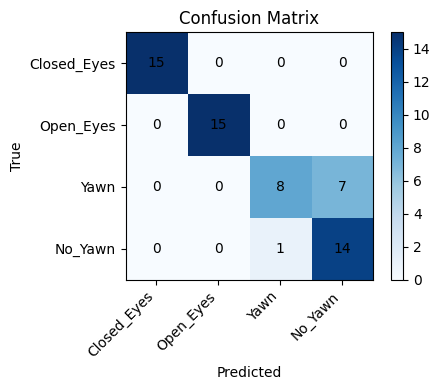

Saved report to: results/cnn_lstm_report_20251011-173456_cnnlstm.txt


In [19]:
test_loss, test_acc = model.evaluate(Xte_seq, yte_seq, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_prob = model.predict(Xte_seq, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(yte_seq, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(yte_seq, y_pred)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(num_classes)); ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticks(range(num_classes)); ax.set_yticklabels(CLASS_NAMES)
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
plt.colorbar(im, ax=ax); plt.tight_layout(); plt.show()

report_path = f"{RESULTS_DIR}/cnn_lstm_report_{run_id}.txt"
with open(report_path, "w") as f:
    f.write(f"Test accuracy: {test_acc:.4f}\n\n")
    f.write(classification_report(yte_seq, y_pred, target_names=CLASS_NAMES))
print("Saved report to:", report_path)


In [21]:
final_path = f"{MODEL_DIR}/cnn_lstm_final_{run_id}.keras"
model.save(final_path)
with open(f"{MODEL_DIR}/labels.json","w") as fp:
    json.dump({i:c for i,c in enumerate(CLASS_NAMES)}, fp)

print("Saved model to:", final_path)
print("Saved labels to: models/labels.json")


Saved model to: models/cnn_lstm_final_20251011-173456_cnnlstm.keras
Saved labels to: models/labels.json


In [22]:
import cv2

def load_img_rgb(path, target=(64,64)):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target)
    return (img/255.0).astype("float32")

def predict_sequence(paths, model, target=(64,64)):
    frames = np.stack([load_img_rgb(p, target) for p in paths], axis=0)  # (T,H,W,C)
    x = np.expand_dims(frames, axis=0)  # (1,T,H,W,C)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return {"class": CLASS_NAMES[idx], "confidence": float(probs[idx]), "probs": probs.tolist()}

# Example:
# seq_paths = [ "data/sample/closed1.jpg", "data/sample/closed2.jpg", ... ]  # length T
# res = predict_sequence(seq_paths, model); res
